# Getting familiar with DeepInsight

<a href="https://alok-ai-lab.github.io/DeepInsight/">DeepInsight</a><br>
<a href="https://alok-ai-lab.github.io/deepinsight-fs/">DeepInsight-FS</a>

## Installation

In [1]:
!pip install git+git://github.com/alok-ai-lab/DeepInsight.git#egg=DeepInsight

## Imports

In [2]:
from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras import datasets, layers, models

## Dataset

### Path Selection

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd 'drive/Shareddrives/With Myself/huge-datasets-for-colab/DeepInsight'

/content/drive/Shareddrives/With Myself/huge-datasets-for-colab/DeepInsight


### Reading and Splitting data

In [7]:
expr_file = r"tcga.rnaseq_fpkm_uq.example.txt.gz"
expr = pd.read_csv(expr_file, sep="\t")

In [8]:
# y_train.map(remapper)
# expr.head()
expr.shape

(600, 5001)

In [9]:
remapper = {'BRCA':0, 'COAD':1, 'KIRC':2}
expr['project'] = expr['project'].map(remapper)

In [10]:
y = expr['project'].values
X = expr.iloc[:, 1:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y)
X_train.shape

(480, 5000)

### Data Normalizaion

In [11]:
ln = LogScaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

### Transforming the data

**Image Transformer Intialization**

In [12]:
it = ImageTransformer(feature_extractor='tsne', 
                      pixels=50, random_state=1701, 
                      n_jobs=-1)

**Fitting the transformer to the training data**

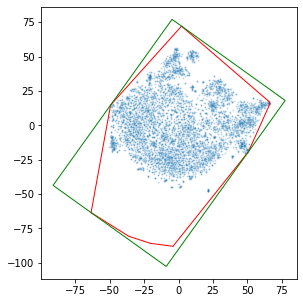

In [13]:
plt.figure(figsize=(5, 5))
it.fit(X_train_norm, plot=True)

**Feature density metrix from the transformer**

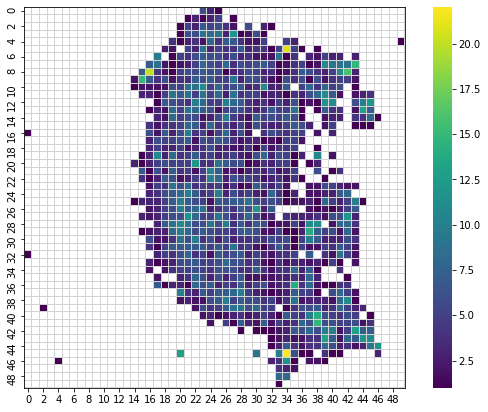

In [14]:
fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.01, 
                 linecolor="lightgrey", square=True)
for _, spine in ax.spines.items():
    spine.set_visible(True)

**Transforming the training data**

In [15]:
mat_train = it.transform(X_train_norm)

Instead of two seperate process, it can also done in a single step:

In [16]:
#mat_train = it.fit_transform(X_train_norm)

Let's view some transformed images

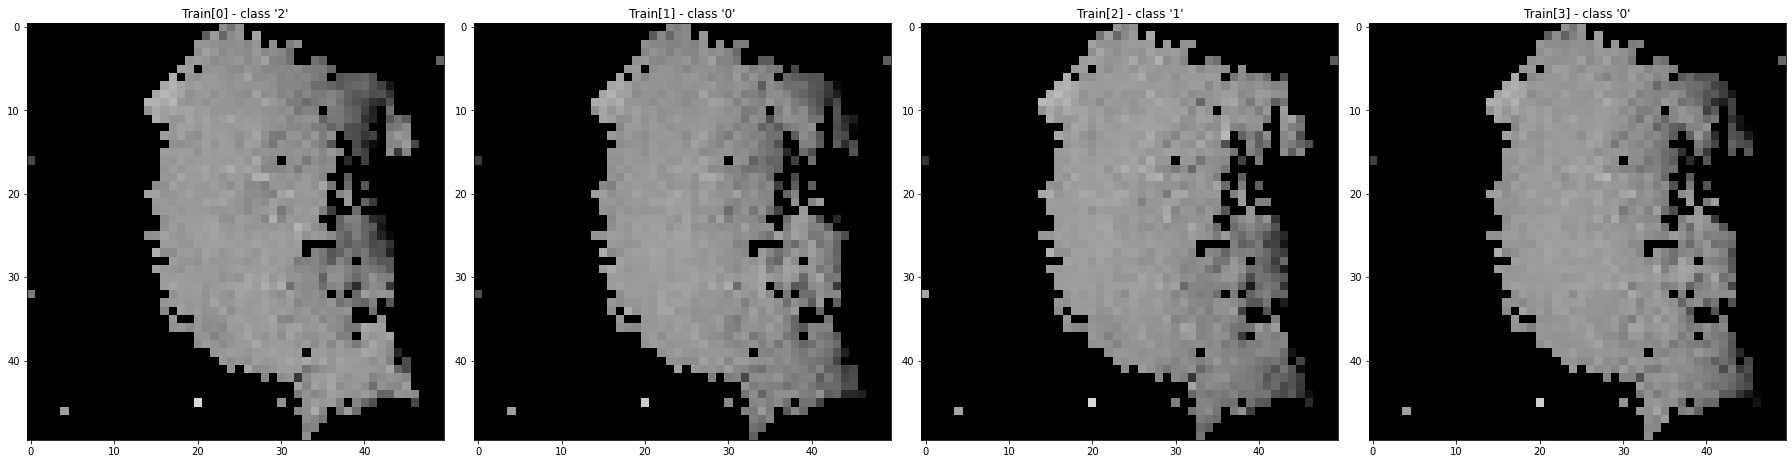

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
for i in range(0,4):
    ax[i].imshow(mat_train[i])
    ax[i].title.set_text("Train[{}] - class '{}'".format(i, y_train[i]))
plt.tight_layout()

**Transforming the test data with the transformer that is fitted with train data**

In [18]:
mat_test = it.transform(X_test_norm)

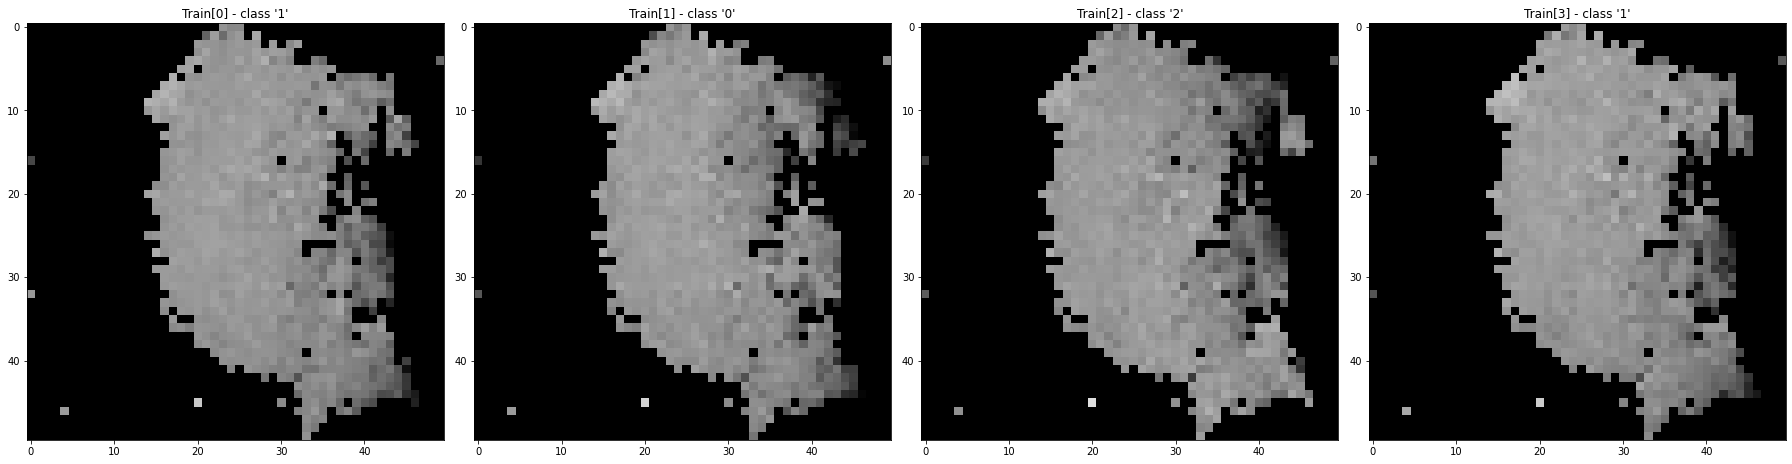

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
for i in range(0,4):
    ax[i].imshow(mat_test[i])
    ax[i].title.set_text("Train[{}] - class '{}'".format(i, y_test[i]))
plt.tight_layout()

Now, all the data is ready for a CNN model.

## CNN Model

### Creating the model

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(50,50,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

In [21]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.fit(
    x=mat_train,
    y=y_train,
    batch_size=128,
    epochs=5,
)

Epoch 1/5
4/4 [==============================] - 2s 384ms/step - loss: 1.1188 - accuracy: 0.3535
Epoch 2/5
4/4 [==============================] - 2s 390ms/step - loss: 1.0881 - accuracy: 0.5030
Epoch 3/5
4/4 [==============================] - 2s 390ms/step - loss: 1.0756 - accuracy: 0.3948
Epoch 4/5
4/4 [==============================] - 2s 383ms/step - loss: 1.0482 - accuracy: 0.5953
Epoch 5/5
4/4 [==============================] - 2s 384ms/step - loss: 0.9879 - accuracy: 0.5171


In [25]:
test_loss, test_accuracy = model.evaluate(mat_test, y_test, verbose=2)

4/4 - 0s - loss: 0.9129 - accuracy: 0.8250
